## **Informe final carrera**

Para el Informe final de la carrera elegí seguir trabajando con el dataset del Proyecto 3, Amazon reviews, y Procesamiento del lenguaje natural (NLP).

Voy a plantear 2 desafíos para implementar:   
   
**1- Mejorar el preproceamiento del dataset**: en el proyecto 3 solamente utilicé una de las columnas disponibles para entrenar a mi modelo, pero creo que utilizar el resto de la información relevante podría traducirse en mejoras en los resultados de performance del modelo.    
**2- Implementar un nuevo modelo de Machine learning: Redes neuronales.** Este modelo no ha sido aplicado en los proyectos anteriores y considero que hoy en día es una solución muy eficaz para muchos de los problemas actuales. Por este motivo, parte del desafío es aprender a implementarlo y evaluar si es de utilidad frente a este problema de NLP.  

In [7]:
# Importo las librerías
import numpy as np
from numpy import asarray
from numpy import save
from numpy import load
import itertools
import pandas as pd
pd.options.display.max_columns = None
pd.set_option('display.max_colwidth', None)

import nltk
nltk.download('punkt')
nltk.download('stopwords')
import re
import spacy
import string

import xgboost as xgb
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior() 
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'

[nltk_data] Downloading package punkt to /home/lulu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/lulu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### **1- Preprocesamiento de datos**

A diferencia el Proyecto 3 en el que sólo utilicé la columna review_body, en este proyecto voy a agregar la información de review_title y product_category. 

En el análisis exploratorio del Proyecto 3 fue posible ver que la distribución de stars no era igual para todas las **cateogorías de producto**, de manera que esta información puede ser relevante para la performance del modelo. 

En el caso del **review_title**, en una inspección rápida se observa que no solamente aparece el título del producto, sino que en algunos casos el usuario aporta información sobre la crítica del producto, que puede emplearse para complementar el texto del review_body. Voy a comenzar evaluando si existen palabras diferenciales asociadas a cada star en review_title para considerar incorporar esta información en el análisis.

In [4]:
# Importo el dataset de entrenamiento, utilizo la libería pandas
data = pd.read_json('dataset_es_train.json', lines= True)
data.head(2)

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8 meses y no he recibido respuesta del fabricante,television Nevir,es,electronics
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ni nosotros que sabemos inglés, ni un informático, después de una hora fue capaz de instalarlo",Dinero tirado a la basura con esta compra,es,electronics


In [5]:
# Creo datasets para cada categoría de estars
data_1_star = data[data['stars'] == 1]
data_2_stars = data[data['stars'] == 2]
data_3_stars = data[data['stars'] == 3]
data_4_stars = data[data['stars'] == 4]
data_5_stars = data[data['stars'] == 5]

stopwords = nltk.corpus.stopwords.words('spanish')

# Luego de evaluar la lista de stopwords, decido dejar algunas palabras que pueden ser relevantes para el trabajo
palabras = ['muy', 'no', 'si', 'sin', 'sentido', 'sentida', 'sintiendo', 'siente', 'contra', 'muchos', 'poco', 'más', 
            'pero', 'porque', 'tanto', 'sentidos', 'sería', 'fuese', 'tuvo', 'tendría', 'tuviese']
stopwords = [palabra for palabra in stopwords if palabra not in palabras]

# Función para evaluar la frecuencia de palabras
def freq_palabras_title(dataset):
    review_title_data = []
# Agrego las review_title
    name =[x for x in globals() if globals()[x] is dataset][0]
    for i in range(dataset.shape[0]):
        review_title_ = dataset.iloc[i].review_title
        review_title_ = review_title_.lower()
        review_title_ = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(review_title_)  # [\w]+ Para reconocer caracteres alfanuméricos
        # Pasamos todo a minúsculas

        review_title_ = [word for word in review_title_ if word not in stopwords]
#     review_body_ = [word for word in titular if word not in filtrar]
        review_title_data.append(review_title_)
    
    review_title_data = list(itertools.chain(*review_title_data))
    freq_data = nltk.FreqDist(review_title_data)
    df_data_title = pd.DataFrame(list(freq_data.items()), columns = ["Word","Frequency"])
    df_data_title.sort_values('Frequency',ascending=False, inplace = True)
    df_data_title.reset_index(drop = True, inplace=True)
    
    plt.figure(figsize = (10, 6))
    plt.title('Palabras más frecuentes en dataset %s' %name, fontsize=15)
    plot = sns.barplot(x  = df_data_title.iloc[:20].Word, y = df_data_title.iloc[:20].Frequency)
    
    for item in plot.get_xticklabels():
        item.set_rotation(90)
    plt.show()
    return

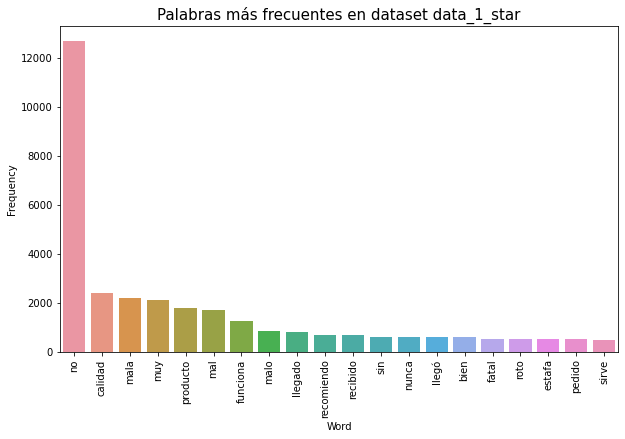

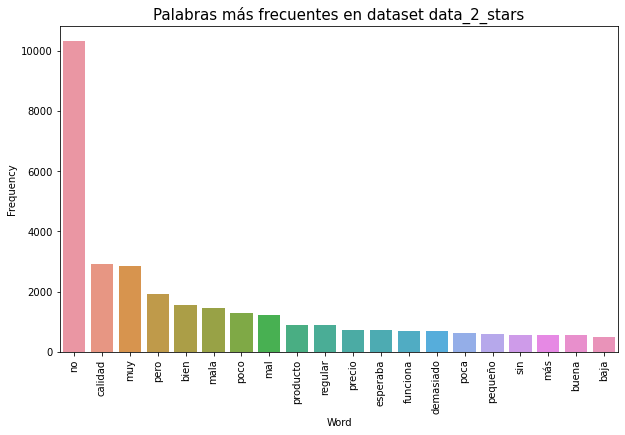

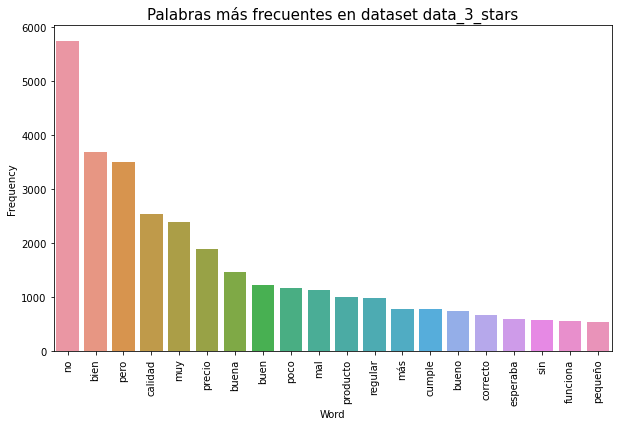

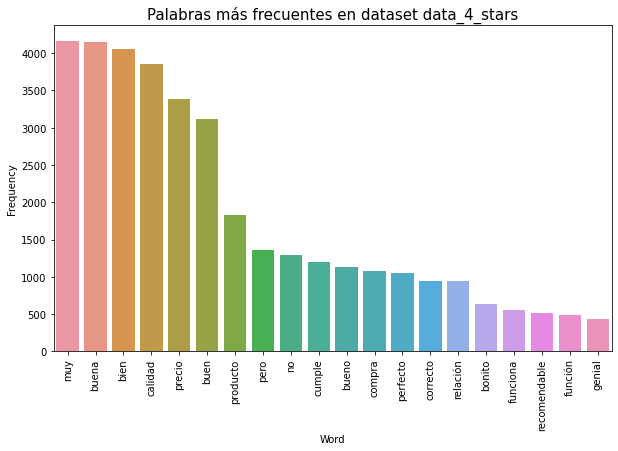

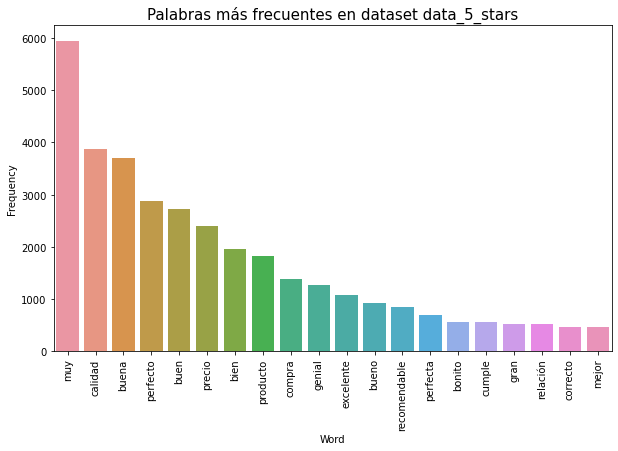

In [8]:
# Recorro los datasets según el filtro de 2, 3 4 y 5 estrellas para ver cuál es la distribución de palabras mśa frecuentes.
datasets = [data_1_star, data_2_stars, data_3_stars, data_4_stars, data_5_stars]

for i in datasets:
    freq_palabras_title(i)

Se observa que hay palabras más asociadas a cada categoría de stars como era esperable. Palabras de connotación negativa como "no", "mala" o "mal" se asocian más a 1 star mientras que otras palabras de connotación positiva como "buena", "perfecto" o "buen" se asocian más a 5 stars.

Por este motivo decido incorporar además de product_category, el feature review_title al análisis en este proyecto.

A continuación comienzo el preprocesamiento de datos consistente en unir las columnas review_body, review_title y product_category para posteriormente realizar la Lemmatización y la aplicación de CountVectorizer (Bag of words) + TF-IDF.

In [ ]:
# Elimino las columnas que no voy a utilizar en mi modelo
data = data.drop(['review_id', 'product_id', 'reviewer_id', 'language'], axis = 1)

In [ ]:
# Creo una nueva columna que contenga la información de review_body + review_title + product_category
data['review'] = data['review_body'].str.cat(data['review_title'],sep=" ")
data['review_title_cat'] = data['review'].str.cat(data['product_category'],sep=" ")

# Elimino las columnas que no voy a utilizar en mi modelo
data = data.drop(['review_body', 'review_title', 'product_category', 'review'], axis = 1)
data.head(2)

,stars,review_title_cat
0,1,Nada bueno se me fue ka pantalla en menos de 8 meses y no he recibido respuesta del fabricante television Nevir electronics
1,1,"Horrible, nos tuvimos que comprar otro porque ni nosotros que sabemos inglés, ni un informático, después de una hora fue capaz de instalarlo Dinero tirado a la basura con esta compra electronics"


Voy a eliminar mayúsculas, caracteres no alfanuméricos de review_title_cat. Para esto empleo la libería nltk.

In [ ]:
review_body=[]
for review in data.review_title_cat:
    # Vamos a reemplzar los caracteres que no sean leras por espacios
    review=re.sub("[^a-zA-Z]"," ",str(review))
    # Pasamos todo a minúsculas
    review=review.lower()
    # Tokenizamos para separar las palabras del titular
    review=nltk.word_tokenize(review)
    #Volvemos a unir el review
    review=" ".join(review)
    # Vamos armando una lista con todos los titulares
    review_body.append(review)

In [ ]:
data["review_1"] = review_body
data = data.drop('review_title_cat', axis = 1)

In [ ]:
data.head(2)

,stars,review_1
0,1,nada bueno se me fue ka pantalla en menos de meses no he recibido respuesta del fabricante television nevir electronics
1,1,horrible nos tuvimos que comprar otro porque ni nosotros que sabemos ingl ni un inform tico despu de una hora fue capaz de instalarlo dinero tirado la basura con esta compra electronics


In [ ]:
# Guardo el archivo
data.to_csv (r'/home/lulu/Documents/Acámica/data_proyecto4.csv', index = False, header=True)

In [ ]:
data = pd.read_csv('data_proyecto4.csv')
data.dropna(axis=0,inplace=True)  # Descarto nan
data.head()

,stars,review_1
0,1,nada bueno se me fue ka pantalla en menos de meses no he recibido respuesta del fabricante television nevir electronics
1,1,horrible nos tuvimos que comprar otro porque ni nosotros que sabemos ingl ni un inform tico despu de una hora fue capaz de instalarlo dinero tirado la basura con esta compra electronics
2,1,te obligan comprar dos unidades te llega solo una no hay forma de reclamar una autentica estafa no compreis solo llega una unidad cuando te obligan comprar dos drugstore
3,1,no entro en descalificar al vendedor solo puedo decir que tras dos meses de espera sigo sin el producto tuve que contactar con amazon para reclamar su reembolso amazon un se hace cargo del problema pero yo desembolsado mi dinero en dos meses me lo devuelven perdida de tiempo total sin palabras ustedes deciden producto no recibido wireless
4,1,llega tarde co la talla equivocada devuelto shoes


**Lemmatización**

Elijo esta metodología en lugar de la Stemmización, ya que si bien es computacionalmente más costoso, me permite ir a la raíz de la palabra utilizando el contexto y la función de la palabra en el texto. Debido a que el dataset se encuentra en español NLTK no ha funcionado bien para realizar la lemmatización (no dispone de librerías para este proceso en español) por lo que decido utilizar **spaCy v3.0** que cuenta con buenas referencias para este proceso.

In [ ]:
# Cargo el modelo del lenguaje en español, para esto empleo spacy
nlp = spacy.load("es_dep_news_trf")

In [ ]:
# Función para lemmatizar con spacy
def spacy_lemma(dataset):
    lem_list=[]
    for review_body in dataset.review_1:
        # Convierto a nlp 
        doc = nlp(review_body)
        # Lemmatización
        output = [word.lemma_ for word in doc] 
        # Por ultimo volvemos a unir el titular
        output = " ".join(output)
        # Uno a la lista vacía
        lem_list.append(output)
        # pd.set_option('display.max_colwidth', None)      
    dataset["review_lemm"] = lem_list  
    return

In [ ]:
# Llamo a la función 
spacy_lemma(data)
# Guardo el dataset lemmatizado
data.to_csv (r'/home/lulu/Documents/Acámica/data_proyecto4_lemma.csv', index = False, header=True)

Realizo el mismo preprocesamiento con el set de testeo

In [ ]:
data_test = pd.read_json('dataset_es_test.json', lines= True)
# Elimino las columnas que no voy a utilizar en mi modelo
data_test = data_test.drop(['review_id', 'product_id', 'reviewer_id', 'language'], axis = 1)
data_test['review'] = data_test['review_body'].str.cat(data_test['review_title'],sep=" ")
data_test['review_title_cat'] = data_test['review'].str.cat(data_test['product_category'],sep=" ")

# Elimino las columnas que no voy a utilizar en mi modelo
data_test = data_test.drop(['review_body', 'review_title', 'product_category', 'review'], axis = 1)

review_body2 = []
for review in data_test.review_title_cat:
    # Vamos a reemplzar los caracteres que no sean leras por espacios
    review=re.sub("[^a-zA-Z]"," ",str(review))
    # Pasamos todo a minúsculas
    review=review.lower()
    # Tokenizamos para separar las palabras del titular
    review=nltk.word_tokenize(review)
    #Volvemos a unir el review
    review=" ".join(review)
    # Vamos armando una lista con todos los titulares
    review_body2.append(review)
    
data_test["review_1"] = review_body2
data_test = data_test.drop('review_title_cat', axis = 1)
data_test.dropna(axis=0,inplace=True)  # Descarto nan

# Guardo el archivo
data_test.to_csv (r'/home/lulu/Documents/Acámica/data_test_proyecto4.csv', index = False, header=True)

data_test.head()

,stars,review_1
0,1,no me llego el articulo me lo mando por correos normal sin seguimiento y nunca me llego tota un desastre no me llego wireless
1,1,la mensajer a horrible no compro mas amazon sigue sin cumplir en las entregas home
2,1,estoy muy decepcionado con el vendedor ya que el pedido no me lleg a tiempo y no cumpli los plazos de env o y era una cosa que necesitaba urgente para colmo me pongo en contacto con el vendedor y no da se ales no recomiendo nada estafa en el env o toy
3,1,mi valoraci n no es sobre el producto sino sobre amazon ofrec is el producto a y tras varios d as me devolv is el dinero porque os hab is equivocado en el anuncio seg n vosotros ahora es es la primera vez que me ocurre esto cuando he comprado en cualquier sitio y el precio marcado no se correspond a con el valor de caja siempre me lo han vendido con el precio marcado es inveros mil lo ocurrido pero la ultima palabra me la dar la oficina del consumidor estafa de amazon home
4,1,pues ten a inter s en este libro y prob la versi n kindle se abre la portada pero nada m s parece una mala broma pero me iba a gastar el dedo de tanto tratar que pasara de p gina de alguna forma no puedo valorar nada de nada no consegu pasar de la portada en kindle digital ebook purchase


In [ ]:
# Llamo a la función 
spacy_lemma(data_test)
# Guardo el dataset lemmatizado
data_test.to_csv (r'/home/lulu/Documents/Acámica/data_test_proyecto4_lemma.csv', index = False, header=True)

In [ ]:
# Traigo a los 2 datasets para continuar
data_test = pd.read_csv('data_test_proyecto4_lemma.csv')
data = pd.read_csv('data_proyecto4_lemma.csv')

# Elimino la columna que no voy a utilizar y solamente me quedo con el review lemmatizado
data_test = data_test.drop('review_1', axis = 1)
data = data.drop('review_1', axis = 1)

In [ ]:
data.head()

,stars,review_lemm
0,1,nada bueno él yo ser ko pantalla en menos de mes no haber recibir respuesta del fabricante television nevir electronics
1,1,horrible yo tener que comprar otro porque ni yo que saber ingl ni uno inform tico despu de uno hora ser capaz de instalar él dinero tirado el basura con este compra electronics
2,1,tú obligar comprar dos unidad tú llegar solo uno no haber forma de reclamar uno autentico estafa no compreis solo llegar uno unidad cuando tú obligar comprar dos drugstore
3,1,no entrar en descalificar al vendedor solo poder decir que tras dos mes de espera seguir sin el producto tener que contactar con amazon para reclamar su reembolso amazon uno él hacer cargo del problema pero yo desembolsado mi dinero en dos mes yo él devolver perdido de tiempo total sin palabra tú decidir producto no recibido wireless
4,1,llegar tarde co el talla equivocado devuelto sho


**Vectorización: TfidfVectorizer**

En esta sección voy a emplear max_features igual a los elegidos para el Proyecto 3 (max_features=500) para poder evaluar solamente la influencia del preprocesamiento en el desempeño de mi mejor modelo de dicho proyecto. En este caso, además del CountVectorizer empleado en el Proyecto 3 agrego TF-IDF (Term frequency – Inverse document frequency) para ponderar mejor a los features del modelo. Empleo la función TfidfVectorizer que es equivalente a realizar CountVectorizer seguido de TfidfTransformer.

In [ ]:
# Train
list_reviews = list(data['review_lemm'].values)
stars = data['stars'].values
# Test
list_reviews_test = list(data_test['review_lemm'].values)
stars_test = data_test['stars'].values

vectorizer = TfidfVectorizer(max_features=500)

# Train
matriz = vectorizer.fit_transform(list_reviews)
x = matriz.toarray()
y = stars

# Test
matriz_test = vectorizer.transform(list_reviews_test)
x_test = matriz_test.toarray()
y_test = stars_test

# Tomamos las palabras
all_words = vectorizer.get_feature_names()

print(x.shape)
print(x_test.shape)

(200000, 500)
(5000, 500)


In [ ]:
# Voy a guardar los arrays "x" e "y" de train y test para entrenar a los modelos posteriormente, empleo la libería numpy
save('x.npy', x)
save('y.npy', y)
save('x_test.npy', x_test)
save('y_test.npy', y_test)

**Modelo: XGBoost**

Voy a comparar el resultado del nuevo preprocesamiento del dataset en relación al anterior, utilizando el mejor modelo elegido en el Proyecto 3, con los hiperparámetros optimizados.

In [ ]:
# Defino el modelo Xgboost
xg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=5,
             min_child_weight=1, monotone_constraints='()',
             n_estimators=400, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
# Entreno el modelo
xg.fit(x,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=400, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
# Realizo las predicciones
y_train_pred_xg = xg.predict(x)
y_test_pred_xg = xg.predict(x_test)

In [ ]:
# Evalúo el modelo con MAE
mae_train_xg = mean_absolute_error(y, y_train_pred_xg)
mae_test_xg = mean_absolute_error(y_test, y_test_pred_xg)

print('MAE en train:', mae_train_xg)
print('MAE en test:', mae_test_xg)

MAE en train: 0.6371122347987525
MAE en test: 0.684425637537241


In [ ]:
# Evalúo el modelo con RMSE
rmse_train_xg = mean_squared_error(y, y_train_pred_xg, squared=False)
rmse_test_xg = mean_squared_error(y_test, y_test_pred_xg, squared=False)
print('RMSE en train:', rmse_train_xg)
print('RMSE en test:', rmse_test_xg)

RMSE en train: 0.8047497019432066
RMSE en test: 0.8627290575729287


### **1- Conclusiones sobre el preprocesamiento de datos**

**XGBoost Regressor Proyecto 3**     
MAE en test: 0.7478    
RMSE en test: 0.9362   

**XGBoost Regressor Proyecto 4**    
MAE en test: 0.6844    
RMSE en test: 0.8627 

Al correr el mejor modelo del Proyecto 3 con un nuevo preprocesamiento de datos, se obseva que el agregado de información extra (review_title y product_category) al cuerpo de la crítica (review_body) es una buena medida para mejorar la performance del modelo al disminuir tanto los valores de MAE como RMSE en las predicciones.

### **2- Red Neuronal Simple**

Para probar este nuevo modelo voy a emplear **Keras**, el cual es un framework de alto nivel para el aprendizaje, escrito en Python y que es capaz de correr sobre diferentes frameworks. En este caso utilizaré Keras para correr sobre **Tensorflow**. 

Empleando Keras es posible crear modelos de aprendizaje supervisado experimentales para resolver un problema en concreto, en este caso predecir stars (1 al 5) a partir de datos de la crítica de un producto realizada por un usuario/a.

In [3]:
# Cargo X e Y de train y test set
x = np.load('x.npy')
y = np.load('y.npy')
x_test = np.load('x_test.npy')
y_test = np.load('y_test.npy')

In [ ]:
# Shape de set de entrenamiento y testeo
print("X_train shape:", x.shape)
print("y_train shape:", y.shape)
print("X_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (200000, 500)
y_train shape: (200000,)
X_test shape: (5000, 500)
y_test shape: (5000,)


In [ ]:
# Chequeo cantidad de stars y datos en cada una
values,counts = np.unique(y, return_counts=True)
print("Values:", values)
print("Counts:", counts)

Values: [1 2 3 4 5]
Counts: [40000 40000 40000 40000 40000]


**Red neuronal simple**

Voy a comenzar probando una red neuronal simple, con hiperparámetros por default, para evaluar el punto de partida del modelo.

No utilizo función de activación en la última capa debido a que es un problema de regresión y busco predecir valores númericos (1 a 5 star) sin transformar. 

Agrego también al modelo el Dropout que es una técnica de regularización propuesta por Srivastava, et al. (2014) en su trabajo "Dropout: A Simple Way to Prevent Neural Networks from Overfitting". Con esta técnica se seleccionan al azar algunas neuronas que serán ignoradas durante el entrenamiento para evitar el overfitting.


In [ ]:
model1 = Sequential()
model1.add(Dense(100, kernel_initializer='normal', activation='relu', name="Input_layer"))
model1.add(Dropout(0.2))
model1.add(Dense(100, activation='relu', name="Hidden_layer_1"))
model1.add(Dropout(0.2))
model1.add(Dense(1, kernel_initializer='normal', name="Output_layer"))
optimizer = tf.keras.optimizers.Adam()
model1.compile(loss='mean_absolute_error', metrics=[tf.keras.metrics.RootMeanSquaredError()], optimizer=optimizer)

# Entreno el modelo y guardo las métricas en history
history = model1.fit(x, y, batch_size=32, epochs=10, verbose=1, validation_data=(x_test, y_test))

Epoch 1/10
6250/6250 [==============================] - 14s 2ms/step - loss: 0.8429 - root_mean_squared_error: 1.3171 - val_loss: 0.6631 - val_root_mean_squared_error: 0.9738
Epoch 2/10
6250/6250 [==============================] - 12s 2ms/step - loss: 0.6930 - root_mean_squared_error: 0.9613 - val_loss: 0.6498 - val_root_mean_squared_error: 0.9335
Epoch 3/10
6250/6250 [==============================] - 12s 2ms/step - loss: 0.6669 - root_mean_squared_error: 0.9272 - val_loss: 0.6367 - val_root_mean_squared_error: 0.9127
Epoch 4/10
6250/6250 [==============================] - 12s 2ms/step - loss: 0.6494 - root_mean_squared_error: 0.9083 - val_loss: 0.6610 - val_root_mean_squared_error: 0.8986
Epoch 5/10
6250/6250 [==============================] - 12s 2ms/step - loss: 0.6342 - root_mean_squared_error: 0.8951 - val_loss: 0.6218 - val_root_mean_squared_error: 0.8880
Epoch 6/10
6250/6250 [==============================] - 12s 2ms/step - loss: 0.6283 - root_mean_squared_error: 0.8855 - val_l

Para el set de validación (test) la métrica obtenida con una red neuronal simple fue RMSE = 0.8553 y MAE: 0.6171. 

El desempeño es muy similar al obtenido con el modelo XGBoost Regressor (RMSE = 0.8627 y MAE = 0.6844), por lo que probablemente, la optimización y agregado de capas internas puedan ayudar a mejorar la performance del modelo.

In [16]:
# Defino una función para crear un modelo, que es necesaria para KerasRegressor
def create_model2(learning_rate=0.01):
    model = Sequential()
    model.add(Dense(100, kernel_initializer='normal', activation='relu', name="Input_layer"))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu', name="Hidden_layer_1"))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='normal', name="Output_layer"))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='mean_absolute_error', metrics=[tf.keras.metrics.RootMeanSquaredError()], optimizer=optimizer)
    return model
  
# Creo el modelo
model2 = KerasRegressor(build_fn=create_model2, batch_size=32, verbose=0)

# Defino los parámetros para grid search
learning_rate = [0.001, 0.01, 0.1]
epochs = [15, 20, 30]
param_grid = dict(learning_rate=learning_rate, epochs=epochs)

grid2 = GridSearchCV(estimator=model2, param_grid=param_grid, n_jobs=-1)
grid_result2 = grid2.fit(x, y)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [17]:
# Resumen de resultados
print("Mejor resultado: %f , obtenido empleando %s" % (grid_result2.best_score_, grid_result2.best_params_))
means2 = grid_result2.cv_results_['mean_test_score']
stds2 = grid_result2.cv_results_['std_test_score']
params2 = grid_result2.cv_results_['params']

for mean, stdev, param in zip(means2, stds2, params2):
    print("%f (%f) with: %r" % (mean, stdev, param))

Mejor resultado: -1.121527 , obtenido empleando {'epochs': 20, 'learning_rate': 0.001}
-1.153162 (0.237746) with: {'epochs': 15, 'learning_rate': 0.001}
-1.158629 (0.277290) with: {'epochs': 15, 'learning_rate': 0.01}
-1.369463 (0.409713) with: {'epochs': 15, 'learning_rate': 0.1}
-1.121527 (0.206526) with: {'epochs': 20, 'learning_rate': 0.001}
-1.126206 (0.277854) with: {'epochs': 20, 'learning_rate': 0.01}
-1.365103 (0.483176) with: {'epochs': 20, 'learning_rate': 0.1}
-1.139939 (0.212981) with: {'epochs': 30, 'learning_rate': 0.001}
-1.146205 (0.194187) with: {'epochs': 30, 'learning_rate': 0.01}
-1.615392 (0.729988) with: {'epochs': 30, 'learning_rate': 0.1}


Evalúo con los hiperparámetros learning_rate y epchos optimizados

In [4]:
model = Sequential()
model.add(Dense(100, kernel_initializer='normal', activation='relu', name="Input_layer"))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu', name="Hidden_layer_1"))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='normal', name="Output_layer"))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='mean_absolute_error', metrics=[tf.keras.metrics.RootMeanSquaredError()], optimizer=optimizer)

# Entreno el modelo y guardo las métricas en history
history = model.fit(x, y,
          batch_size=32, epochs=20,
          verbose=0,
          validation_data=(x_test, y_test))

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (Dense)          (None, 100)               50100     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
Hidden_layer_1 (Dense)       (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
Output_layer (Dense)         (None, 1)                 101       
Total params: 60,301
Trainable params: 60,301
Non-trainable params: 0
_________________________________________________________________


Podemos ver que a pesar de ser un modelo simple de red neuronal, tiene que entrenar más de 60 mil parámetros.

In [ ]:
# Para probar predicciones
salida = model.predict(x_test[2998:3003])
print(y_test[2998:3003])
print('Salida:',salida)

In [7]:
#Defino una función para graficar loss y metrics del modelo, para eso empleo la libería matplotlib

# Para saber qué nombres llamar al histograma de loss y metrics
# print(history.history.keys())

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Root_mean_squared_error')
    plt.title('RMSE vs Epoch')
    plt.plot(hist['epoch'], hist['root_mean_squared_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_root_mean_squared_error'],
           label = 'Val Error')
    plt.legend()
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean absolute error')
    plt.title('MAE vs Epoch')
    plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
    plt.legend()
    plt.show()
    return

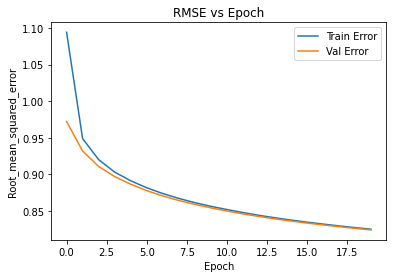

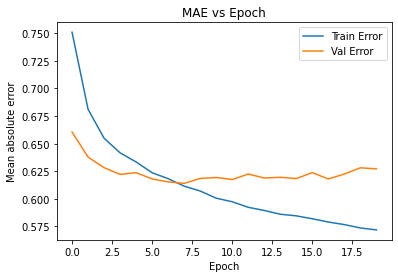

In [8]:
plot_history(history)

En el caso de esta red neuronal casi no se detecta overfitting ni underfitting, debido a que a pesar de el error absoluto (MAE) es menor en el train set, los valores son bastante similares y casi no hay diferencia en el valor de RMSE en ambos sets.

In [5]:
# Predigo sobre el test set
y_test_pred = model.predict(x_test)
# Predigo sobre el train set
y_train_pred = model.predict(x)

# Guardo y_test_pred e y_train_pred
save('y_test_pred.npy', y_test_pred)
save('y_train_pred.npy', y_train_pred)

In [4]:
# Estas celdas son opcionales, en caso de que se quieran analizar las predicciones en otro momento futuro

# y_test_pred = np.load('y_test_pred.npy')
# y_train_pred = np.load('y_train_pred.npy')

# x = np.load('x.npy')
# y = np.load('y.npy')
# x_test = np.load('x_test.npy')
# y_test = np.load('y_test.npy')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


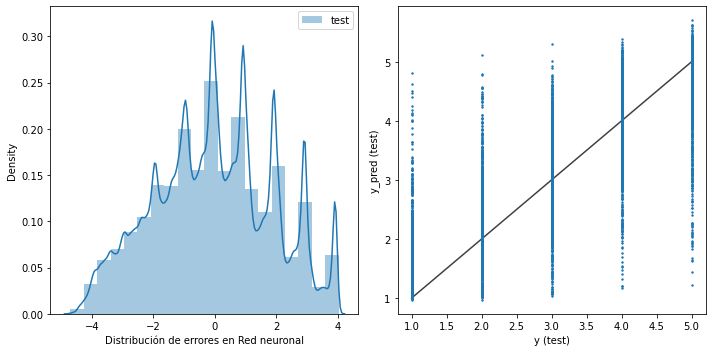

In [8]:
# Grafico los errores
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
# sns.distplot(y - y_train_pred, bins = 20, label = 'train')
sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
plt.xlabel('Distribución de errores en Red neuronal')
plt.legend()
ax = plt.subplot(1,2,2)
ax.scatter(y_test,y_test_pred, s =2)
# lims = [1, 6]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
# ax.plot(lims, lims, 'k-', alpha=0.75)
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')
plt.tight_layout()
plt.show()

Es posible ver que la mayor parte de los errores tienen valores positivos (y real - y predicho > 0), es decir que el modelo tiene mayor tendencia a predecir números de menor valor que el real. También se observa que la mayor frecuencia de errores es de 0, y continúa en valores decrecientes hacia los números mayores.

Se observa que la mayor parte de los errores se cometen en los extremos (1 y 5) en donde la distribución de puntos es mayor a 1 para la categría 1 star y menor a 5 para 5 stars (respecto a los valores centrales 2, 3 y 4).



## **Conclusiones finales**

**XGBoost Regressor Proyecto 3** (Benchmark del Proyecto 4)     
MAE en test: 0.7478    
RMSE en test: 0.9362

**XGBoost Regressor Proyecto 4** (Mejoras en el preprocesamiento)   
MAE en test: 0.6844   
RMSE en test: 0.8627

**Red Neuronal Proyecto 4** (Red neuronal sin optimizar)    
MAE en test: 0.6171   
RMSE en test: 0.8553

**Red Neuronal Proyecto 4** (Con optimización de hiperparámetros)    
MAE en test: 0.6181   
**RMSE en test: 0.8257**

Se evidencia que los cambios en el preprocesamiento de los datos contirbuye a la mejora del modelo (XGBoost Regressor del Proyecto 3 vs Proyecto 4). También es notoria la mejora de una red neuronal con hiperparámetros optimizados respecto del modelo XGBoost Regressor, demostrada en la disminución tanto de MAE como en RMSE.  

Con perspectivas futuras, sería apropiado ahondar en optimizar la arquitectura de la red neuronal, otros hiperparámetros de interés y evaluar la posibilidad de conocer cuáles son los features más importantes para el modelo. Es intersante observar que para concretar muchos de estos objetivos es necesaria una buena capacidad computacional, debido al tiempo y recursos que demanda poner en práctica una red neuronal. 


Github en donde se encuentra disponible este proyecto y los anteriores:
https://github.com/lusoken.